# Определение стоимости автомобилей

## Описание проекта

### Цель проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Критерии, которые важны заказчику:

- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки модели будет применяться метрика RMSE, значение метрики для модели должно быть меньше 2500.

### Описание данных

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

### Импорт библиотек и данных

Импортируем необходимые для работы библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams

rcParams["figure.figsize"] = 8, 5

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error

Импортируем данные

In [3]:
path = "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1w0V8ChyR_PLfrxOyVN6rMxOCRXSL6pW9"
df = pd.read_csv(path)

Сделаем первичный обзор данных для постановки первых задач на предобработку данных.

In [4]:
def data_preview(data):
    display(data.head(5))
    print("-" * 100)
    data.info()
    print("-" * 100)
    print("Пропуски в данных")
    display(data.isna().mean().sort_values(ascending=False))
    print("-" * 100)
    print(f"Количество явных дубликатов - {data.duplicated().sum()}")
    print("-" * 100)
    display(data.describe())

In [5]:
data_preview(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode     

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

----------------------------------------------------------------------------------------------------
Количество явных дубликатов - 4
----------------------------------------------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


После первичного обзора данных можно отметить следующее:
* в нашем распоряжении данные о почти 355 тыс автомобилях, для которых указаны 15 параметров и целевой признак - цена
* первым делом необходимо преобразовать названия столбцов в snake_case для дальнешей работы с данными
* в графах с указаниями модели автомобиля, сведений о наличия ремонта, типов кузова, топлива, коробки передач имеются пропуски, на стадии анализа данных необходимо рассмотреть возможность их заполнения
* также в данных присутствуют явные дубликаты, учитывая, что в данных присутствует информация о времени регистрации анкеты и времени скачивания анкеты из базы (и в этих данных нет пропусков), эти дубликаты несут информацию об одном и том же объекте, и следовательно нужно удалить эти дубликаты
* также необходимо преобразовать все поля с данными о датах в формат datetime
* ну и сразу же обращает на себя внимание графа с количеством картинок - она полностью заполнена нулями и соответственно не несет никакой информации для нас, можно сразу же избавиться от нее
* если быстро взглянуть на статистические данные, то сразу можно обратить внимание на аномальные значения в годах регистрации авто (минимум - 1000, максимум - 9999) и мощности двигателя (минимум - 0, максимум - 20000), в дальнейшем нужно обработать аномалии 

### Предобработка данных

#### Переименование столбцов

Начнем подготовку наших данных для анализа и последующего обучения модели.

Приведем название столбцов к snake_case

In [6]:
def camel_to_snake_case(columns_names):
    res_list = []
    for name in columns_names:
        res_name = [name[0].lower()]
        for letter in name[1:]:
            if letter.isupper():
                res_name.append("_")
                res_name.append(letter.lower())
            else:
                res_name.append(letter)
        res_list.append("".join(res_name))
    return res_list

In [7]:
df.columns = camel_to_snake_case(df.columns)
df.sample()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
348209,2016-03-17 14:57:35,1300,sedan,2003,manual,97,rio,90000,11,petrol,kia,no,2016-03-17 00:00:00,0,14197,2016-03-17 14:57:35


Столбцы успешно переименованы

Перед всеми изменениями сделаем копию датафрейма

In [8]:
df_origin = df.copy()

####  Удаление неинформативных признаков

Удалим бесполезный столбец  `number_of_pictures`

In [9]:
df = df.drop("number_of_pictures", axis=1)

#### Удаление явных дубликатов

Удалим явные дубликаты в данных

In [10]:
df = df.drop_duplicates()

#### Преобразование временных типов данных

Преобразуем временны'е данные в формат datetime

In [12]:
for date_column in ["date_crawled", "date_created", "last_seen"]:
    df[date_column] = pd.to_datetime(df[date_column], format="%Y-%m-%d %H:%M:%S")
df.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
not_repaired                  object
date_created          datetime64[ns]
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

Формат успешно преобразован

#### Обработка данных о цене

Посмотрим внимательнее на распределение количественных признаков для выявления аномалий

In [13]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


Начнем с нашего таргета - с цены.

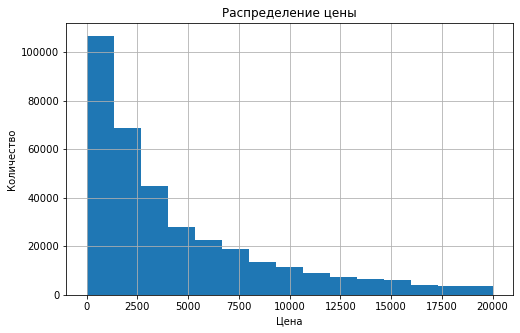

In [14]:
plt.hist(df["price"], bins=15)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Количество")
plt.grid()

С распределением целевого признака у нас все вроде как и должно быть, единственное что может смущать нас - это нулевая цена.

Увеличим масштаб в районе низкой цены

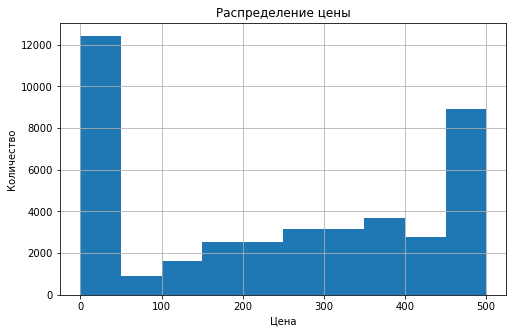

In [15]:
plt.hist(df[df["price"].between(0, 500)]["price"], bins=10)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Количество")
plt.grid()

Мы видим большое количество обьявлений с около нулевой ценой, и так как цена наш целевой признак нам придется удалить эти аномально низкие значения.

In [16]:
len(df[df["price"] < 50]) / len(df)

0.03505707392095721

Получилось почти 3.5% от данных, но машины дешевле 50 евро действительно очень сложно представить

In [17]:
df = df.drop(df[df["price"] < 50].index)

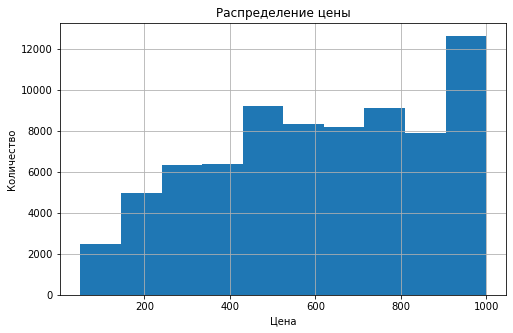

In [18]:
plt.hist(df[df["price"].between(0, 1000)]["price"], bins=10)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Количество")
plt.grid()

С ценой разобрались, теперь посмотрим на год машины

#### Обработка данных с годами регистрации

In [19]:
df["registration_year"].min(), df["registration_year"].max()

(1000, 9999)

Немного необычные значения годов. Посмотрим на распределение годов.

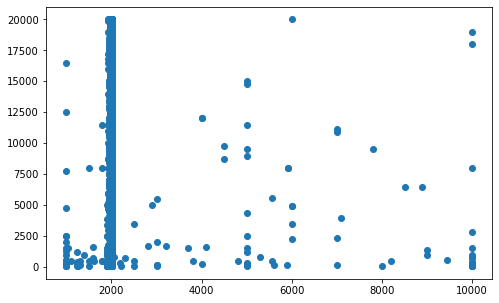

In [20]:
plt.scatter(df["registration_year"], df["price"])

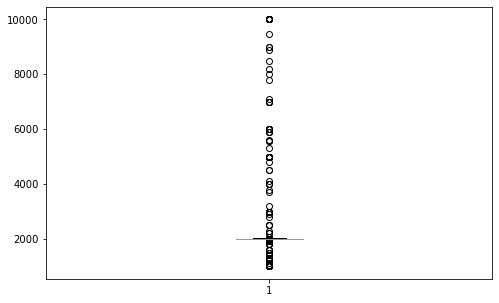

In [21]:
plt.boxplot(df["registration_year"])
plt.show()

Да, встречаются не только 1000 и 9999, но и другие года, которых впринципе не может быть.

Ну и логично предположить, что год регистрации авто никак не может быть больше, чем год создания анкеты.

In [22]:
df["registration_year"] = df["registration_year"].mask(
    df["registration_year"] > df["date_created"].dt.year
)

Остались теперь для обработки ошибочно введенные старые года

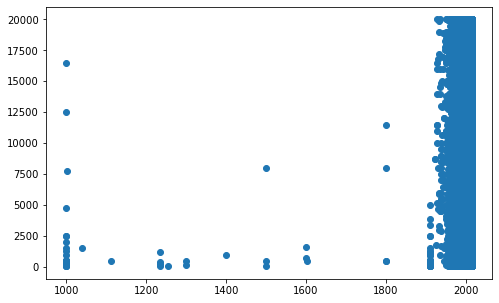

In [24]:
plt.scatter(df["registration_year"], df["price"])

Учитывая, что первый автомобиль был сконструирован в конце 19 века, навряд ли у нас могут встречаться года ниже 1900. А если серъезно, то увеличим масштаб, чтобы отсечь ошибки ввода.

(1875.0, 2000.0)

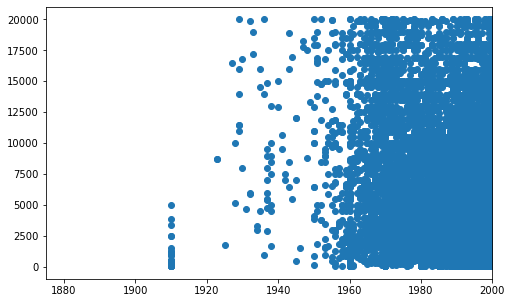

In [25]:
plt.scatter(df["registration_year"], df["price"])
plt.xlim(1875, 2000)

1910 год в нашем случае может служить границей аномально низких (ошибочно введенных годов), хотя конечно автомобили старше 60-х годов тоже сложно себе представить (можно было бы удалить аномально старые года, но сверившись с одним известным сервисом объявлений и найдя там автомобили 30-х годов, решено было оставить старые авто как раритет, хотя наврядли их модель сможет адекватно оценить и они нуждаются в отдельной человеческой оценке)

In [26]:
df["registration_year"] = df["registration_year"].mask(df["registration_year"] <= 1910)

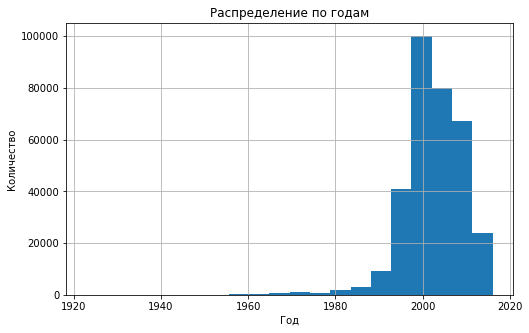

In [27]:
plt.hist(df["registration_year"], bins=20)
plt.title("Распределение по годам")
plt.xlabel("Год")
plt.ylabel("Количество")
plt.grid()

Ну вот уже распределение и по годам у нас стало похоже на правду - отрицательно ассиметричное за счет редких раритетных авто.

In [28]:
df["registration_year"].isna().mean()

0.040328476759216476

Теперь осталось только заполнить образовавшиеся после удаления аномальных значений пропуски. 
Можно было бы заполнить просто медианой, но попробуем посмотреть есть ли какие-либо сколь значимые линейные зависимоти в данных о годах авто.

In [29]:
df.corr()["registration_year"]

price                 0.443686
registration_year     1.000000
power                 0.049337
kilometer            -0.230160
registration_month    0.064557
postal_code           0.031755
Name: registration_year, dtype: float64

Как мы видим год авто (возраст) сильнее всего напрямую коррелирует с ценой, что вполне логично. Поэтому для заполнения пропусков в годах, можно разбить данные с ценами на группы, определить для каждой группы медиану и этой медианой заполнить пропуски в годах в зависимости от того в какую ценовую группу попадает авто.

In [30]:
df["price_bin"] = pd.qcut(df["price"], 10)

In [31]:
df.groupby("price_bin")["registration_year"].agg(["count", "median"])

,count,median
price_bin,,
"(49.999, 600.0]",36418,1998.0
"(600.0, 999.0]",31349,1999.0
"(999.0, 1490.0]",29806,1999.0
"(1490.0, 2000.0]",33625,2000.0
"(2000.0, 2900.0]",32494,2002.0
"(2900.0, 3980.0]",31455,2004.0
"(3980.0, 5500.0]",33571,2005.0
"(5500.0, 7800.0]",32619,2006.0
"(7800.0, 11500.0]",33417,2008.0


In [32]:
price_year_dict = df.groupby("price_bin")["registration_year"].median()

In [33]:
def fillna_year(row):
    if np.isnan(row["registration_year"]):
        row["registration_year"] = price_year_dict.loc[row["price_bin"]]
    return row

In [34]:
df = df.apply(fillna_year, axis=1)

In [35]:
df["registration_year"].isna().mean()

0.0

Отлично пропусков и аномальных годов в данных больше нет.

Посмотрим теперь на распределение данных о мощности двигателя.

#### Обработка данных о мощности двигателя

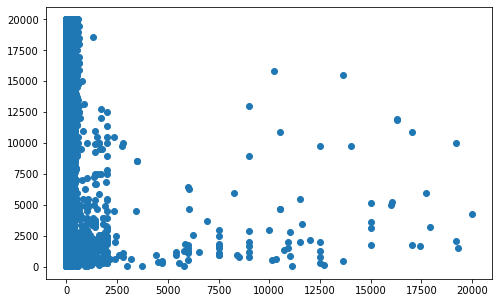

In [36]:
plt.scatter(df["power"], df["price"])

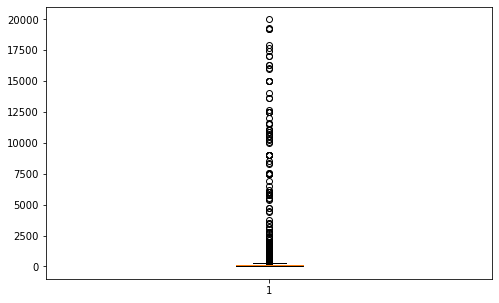

In [37]:
plt.boxplot(df["power"])
plt.show()

В данных о мощности также множество аномалий, во-первых присуствуют нулевые значения, что не может быть впринципе. Также встречаются авто с аномально высокой мощностью (исходя из разных источников максимальная мощность двигателя автомобиля в данный момент достигла 2000 л.с).

Обработаем аномальные данные.

In [38]:
len(df[df["power"] == 0]) / len(df)

0.1039152838785525

У 10% объектов нулевые значения мощности двигателя, что скорее всего свидетельствует об отсутствии данных при заполнении.

In [39]:
df["power"] = df["power"].mask((df["power"] > 2000) | (df["power"] == 0))

In [40]:
df["power"].isna().mean()

0.10423990033397476

У нас теперь в данных о мощности двигателя 10% пропусков (ошибочно введенных данных). Попробуем их заполнить.

In [41]:
price_power_dict = df.groupby("price_bin")["power"].median()
price_power_dict

price_bin
(49.999, 600.0]        75.0
(600.0, 999.0]         78.0
(999.0, 1490.0]        90.0
(1490.0, 2000.0]      101.0
(2000.0, 2900.0]      107.0
(2900.0, 3980.0]      113.0
(3980.0, 5500.0]      116.0
(5500.0, 7800.0]      131.0
(7800.0, 11500.0]     141.0
(11500.0, 20000.0]    169.0
Name: power, dtype: float64

Как и в случае с годами автомобилей мы видим четкую взаимосвязь с увеличением цены растет и мощность двигателя.

In [42]:
def fillna_power(row):
    if np.isnan(row["power"]):
        row["power"] = price_power_dict.loc[row["price_bin"]]
    return row

In [43]:
df = df.apply(fillna_power, axis=1)

Ошибки ввода мы исправили, осталось посмотреть данные на предмет аномально низких и высоких данных

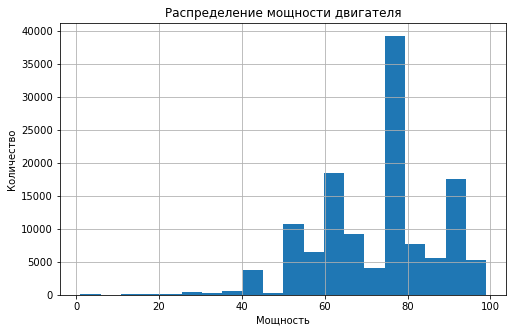

In [44]:
plt.hist(df[df["power"] < 100]["power"], bins=20)
plt.title("Распределение мощности двигателя")
plt.xlabel("Мощность")
plt.ylabel("Количество")
plt.grid()

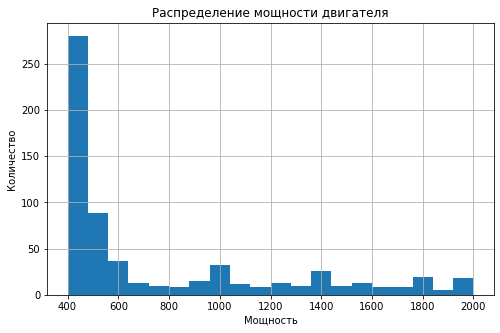

In [45]:
plt.hist(df[df["power"] >= 400]["power"], bins=20)
plt.title("Распределение мощности двигателя")
plt.xlabel("Мощность")
plt.ylabel("Количество")
plt.grid()

Если детальнее посмотреть на гистограммы, а также сверится с данными одного известного интернет-ресурса объявлений, то можно обнаружить, что мощность двигателя у подавляющего большинства авто впринципе находится в пределах от 40 до 600 л.с. Отфильтруем данные о мощности двигателя.

In [46]:
df["power"] = df["power"].mask((df["power"] > 600) | (df["power"] < 40))

In [47]:
df["power"].isna().mean()

0.004635289025624228

Таких аномальных данных у нас меньше половины процента, можно удалить их.

In [48]:
df = df.dropna(subset=["power"])

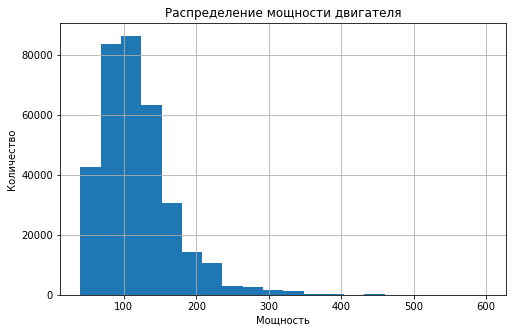

In [49]:
plt.hist(df["power"], bins=20)
plt.title("Распределение мощности двигателя")
plt.xlabel("Мощность")
plt.ylabel("Количество")
plt.grid()

Распределение мощностей двигателей теперь более похоже на правду, но сохранилась асиметрия за счет жирного хвоста мощных машин.

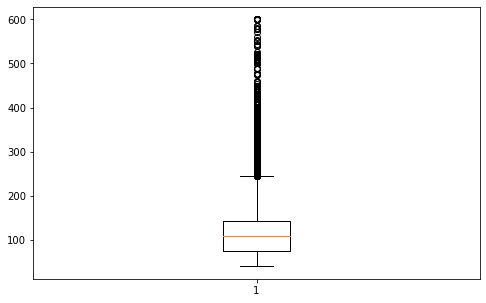

In [50]:
plt.boxplot(df["power"])
plt.show()

In [51]:
df.power.isna().mean()

0.0

В данных о мощности двигателя мы исправили явно ошибочно введенные данные и пропуски при вводе, удалили аномальные данные.

#### Обработка данных о километраже

Посмотрим на распределение пробега авто

In [52]:
df["kilometer"].min(), df["kilometer"].max()

(5000, 150000)

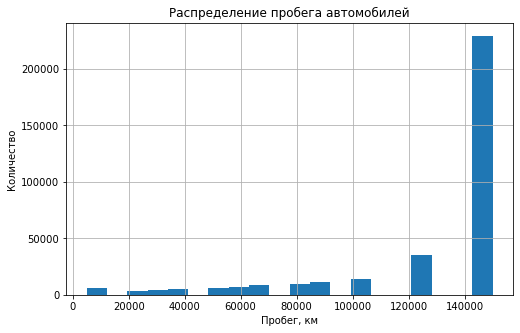

In [53]:
plt.hist(df["kilometer"], bins=20)
plt.title("Распределение пробега автомобилей")
plt.xlabel("Пробег, км")
plt.ylabel("Количество")
plt.grid()

In [54]:
df["kilometer"].value_counts(dropna=False)

150000    229115
125000     35557
100000     14287
90000      11302
80000       9804
70000       8391
60000       7261
50000       6053
5000        4848
40000       4758
30000       4212
20000       3705
10000       1064
Name: kilometer, dtype: int64

Как мы видим размах пробега у нас от 5 до 150 тыс. км, данные по пробегу дискретные (скорее всего округлены), пропусков в данных нет

#### Обработка данных о месяце регистрации 

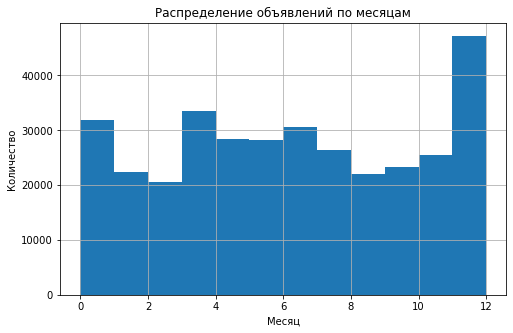

In [55]:
plt.hist(df["registration_month"], bins=12)
plt.title("Распределение объявлений по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество")
plt.grid()

In [56]:
df["registration_month"].min(), df["registration_month"].max()

(0, 12)

<AxesSubplot:xlabel='registration_month'>

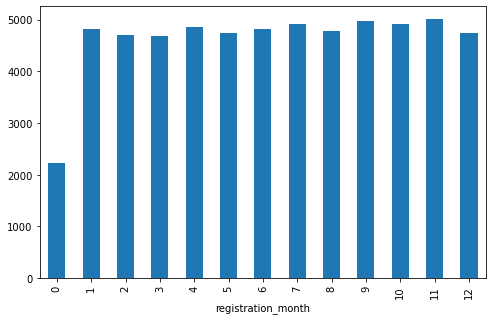

In [57]:
df.groupby("registration_month")["price"].mean().plot(kind="bar")

Во-первых отметим, что в данных присутствуют нули, чего впринципе не может быть, а если вообще оценивать этот признак, то наш таргет вообще от него никак не зависит, что кажется абсолютно логичным (за исключением аномальных 0). Так что для модели этот признак наврядли будет полезен и мы можем удалить его.

In [58]:
df = df.drop("registration_month", axis=1)

Среди количественных переменных у нас остался только почтовый код, но он конечно же не является количественной переменной, не смотря на то, что он указывается с помощью цифр и анализ любых статистик по нему бессмысленен.

Ну а теперь перейдем к кактегориальным переменным, взглянем на них и заполним пропуски по возможности.

#### Обработка данных о марке и моделе авто

Посмотрим для начала нет ли неявных дубликатов в марках автомобилей

In [59]:
sorted(df["brand"].unique())

['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

Единственное место, где могут встретиться дубликаты это ситуация `land_rover` и `rover`. `land_rover` конечно же более популярная марка авто, но и марка `rover` есть, но она довольно редка и вполне верояно, что в нашей выборке это лишь вариант написания `land_rover` . Посмотрим внимательнее на модели этих марок.

In [60]:
df[(df["brand"] == "rover")]["model"].unique()

array(['other', 'discovery', nan, 'rangerover', 'freelander', 'defender'],
      dtype=object)

In [61]:
df[(df["brand"] == "land_rover")]["model"].unique()

array(['discovery', 'freelander', 'defender', nan, 'range_rover',
       'serie_2', 'range_rover_sport', 'other', 'range_rover_evoque',
       'serie_3', 'serie_1'], dtype=object)

Действительно все модели марки `rover` присутствуют в модельном ряду `land_rover`, так что мы можем сказать, что это одна и таже марка. Переименуем дубликаты марки (обратим также внимание на дубликат `rangerover` и `range_rover`)

In [62]:
df = df.replace({"brand": "rover"}, "land_rover")
df = df.replace({"model": "rangerover"}, "range_rover")

С марками авто разобрались, теперь перейдем к моделям. И для начала представим ситуацию, что у нас для обучения модели будут два признака *модели* авто со значением `6`, но *марка* авто будет различна `BMW` и `Жигули` к примеру, мы прекрасно понимаем, что BMW 6-серии будет дороже 'шестерки' Жигулей, но модель без уточнения марки авто именно для этого признака этого не поймет. посмотрим есть ли такие случаи в данных.

In [63]:
df.groupby("model")["brand"].agg(["unique", "nunique"]).sort_values(
    "nunique", ascending=False
).head(10)

,unique,nunique
model,,
other,"[mercedes_benz, volkswagen, hyundai, seat, hon...",38
grand,"[jeep, suzuki, chrysler]",3
3_reihe,"[mazda, peugeot]",2
1_reihe,"[mazda, peugeot]",2
5_reihe,"[mazda, peugeot]",2
matiz,"[chevrolet, daewoo]",2
passat,[volkswagen],1
panda,[fiat],1
pajero,[mitsubishi],1


Выше описанные случаи редки, но есть категория `other` куда сваливают все незаполненные или редкие значения марок, а `other` для Mercedes_benz и `other` для `Hyundai` это в среднем две разные вещи. А у нас ведь еще есть пропуски, которые мы заполним `no_info` к примеру (не будем их смешивать с `other`) (хотя можно было бы пропуски заполнить модой по марке, но это будет не совсем корректно). Так что в графу модель мы добавим информацию о марке автомобиля (для моделей хуже точно не будет), но сначала заполним пропуски.

In [64]:
df["model"] = df["model"].fillna("no_info")

In [65]:
df["model"].isna().mean()

0.0

In [66]:
df["model"] = df["brand"] + "-" + df["model"]

In [67]:
df["model"].isna().mean()

0.0

С марками и моделями авто разобрались.

#### Обработка данных о типе кузова

Посмотрим какие типы кузова нам встречаются.

In [68]:
df["vehicle_type"].value_counts(dropna=False)

sedan          88838
small          77143
wagon          63399
NaN            32799
bus            28234
convertible    19719
coupe          15533
suv            11739
other           2953
Name: vehicle_type, dtype: int64

Неявных дубликатов нет, и можно сделать предположение, что для модели авто характерен определенный тип кузова и пропуски в типах кузова можно заполнить исходя из модели авто.

In [69]:
df.groupby("model")["vehicle_type"].agg(["unique", "nunique"]).sort_values(
    "nunique", ascending=False
).head(15)

,unique,nunique
model,,
toyota-other,"[coupe, small, sedan, nan, suv, bus, wagon, co...",8
peugeot-3_reihe,"[sedan, convertible, nan, small, wagon, suv, c...",8
chevrolet-other,"[sedan, bus, suv, wagon, other, small, coupe, ...",8
mercedes_benz-no_info,"[wagon, sedan, nan, coupe, small, bus, suv, co...",8
opel-vectra,"[sedan, wagon, nan, small, other, coupe, bus, ...",8
mercedes_benz-e_klasse,"[sedan, wagon, nan, coupe, suv, convertible, o...",8
chrysler-no_info,"[convertible, nan, bus, wagon, sedan, suv, sma...",8
mercedes_benz-a_klasse,"[bus, small, nan, sedan, coupe, other, wagon, ...",8
mazda-other,"[bus, small, nan, sedan, suv, other, wagon, co...",8


Но как мы видим это не совсем так, есть модели со всеми типами кузовов и гадать какой именно у тип у пропусков мы не будем, а свалим все пропуски в `no_info`.

In [70]:
df["vehicle_type"] = df["vehicle_type"].fillna("no_info")

#### Обработка данных о типе коробки передач

Посмотрим какие типы коробки передач нам встречаются.

In [71]:
df["gearbox"].value_counts(dropna=False)

manual    259365
auto       64458
NaN        16534
Name: gearbox, dtype: int64

Для заполнения пропусков в типе коробке передач, мы воспользуемся, что этих типов не так уж и много. Мы для каждой модели авто выберем моду по типу коробки передач и заполним пропуски в данных модой по модели автомобиля.

In [72]:
model_gearbox_dict = (
    df.pivot_table(index="model", columns="gearbox", values="brand", aggfunc=["count"])
    .reset_index()
    .fillna(0)
)
model_gearbox_dict.columns = ["model", "auto", "manual"]
model_gearbox_dict = model_gearbox_dict.set_index("model")
model_gearbox_dict["most_freq"] = " "
model_gearbox_dict["most_freq"] = model_gearbox_dict["most_freq"].mask(
    model_gearbox_dict["auto"] - model_gearbox_dict["manual"] <= 0, "manual"
)
model_gearbox_dict["most_freq"] = model_gearbox_dict["most_freq"].mask(
    model_gearbox_dict["auto"] - model_gearbox_dict["manual"] > 0, "auto"
)
model_gearbox_dict

,auto,manual,most_freq
model,,,
alfa_romeo-145,0.0,38.0,manual
alfa_romeo-147,26.0,515.0,manual
alfa_romeo-156,42.0,531.0,manual
alfa_romeo-159,26.0,182.0,manual
alfa_romeo-no_info,7.0,89.0,manual
...,...,...,...
volvo-v40,75.0,646.0,manual
volvo-v50,41.0,208.0,manual
volvo-v60,14.0,26.0,manual


In [73]:
df["gearbox"] = df["gearbox"].fillna("no_info")

In [74]:
def fill_gearbox(row):
    if row["gearbox"] == "no_info":
        row["gearbox"] = model_gearbox_dict.loc[row["model"], "most_freq"]
    return row

In [75]:
df = df.apply(fill_gearbox, axis=1)

In [76]:
df["gearbox"].value_counts(dropna=False)

manual    274097
auto       66260
Name: gearbox, dtype: int64

Пропуски в типах коробок передач заполнились модой по моделям авто.

#### Обработка данных о типе топлива

In [77]:
df["fuel_type"].value_counts(dropna=False)

petrol      208983
gasoline     96788
NaN          28493
lpg           5150
cng            549
hybrid         226
other          120
electric        48
Name: fuel_type, dtype: int64

В данных у нас два основных типа топлива: бензин и дизель, а также большое количество пропусков. Поступим с пропусками в данных о топливе, аналогичным типу коробке передач образом (возьмем моду по модели авто)

In [78]:
model_fuel_dict = (
    df.groupby(["model", "fuel_type"], as_index=False)["brand"]
    .count()
    .sort_values(["model", "brand"], ascending=False)
    .groupby("model")["fuel_type"]
    .first()
)

In [79]:
df["fuel_type"] = df["fuel_type"].fillna("no_info")

In [80]:
def fill_fuel(row):
    if row["fuel_type"] == "no_info":
        row["fuel_type"] = model_fuel_dict.loc[row["model"]]
    return row

In [81]:
df = df.apply(fill_fuel, axis=1)

In [82]:
df["fuel_type"].value_counts(dropna=False)

petrol      233131
gasoline    101133
lpg           5150
cng            549
hybrid         226
other          120
electric        48
Name: fuel_type, dtype: int64

Пропуски в типе топлива заполнились модой по моделям авто.

####  Обработка данных о ремонте авто

In [83]:
df["not_repaired"].value_counts(normalize=True, dropna=False)

no     0.712046
NaN    0.189287
yes    0.098667
Name: not_repaired, dtype: float64

Странное сочетание названия столбца с содержимым (по идее отрицание на отрицание дает утверждение), но в нашем случае отрицание скорее всего означает, что машина в ремонте не была. В итоге мы имеем что 71% авто - не были в ремонте, 19% - без информации, 10% были в ремонте. 

Заполним пропуски в данном случае заглушкой `no_info` (хотя можно бы было заполнить значением по количеству неотремонтированных авто относительно всех и представить это для модели как вероятность отсутствия ремонта, то есть количественным признаком)

In [84]:
df["not_repaired"] = df["not_repaired"].fillna("no_info")

#### Вывод

Все признаки обработаны.

In [85]:
df.isna().mean()

date_crawled         0.0
price                0.0
vehicle_type         0.0
registration_year    0.0
gearbox              0.0
power                0.0
model                0.0
kilometer            0.0
fuel_type            0.0
brand                0.0
not_repaired         0.0
date_created         0.0
postal_code          0.0
last_seen            0.0
price_bin            0.0
dtype: float64

Пропусков в данных больше нет

In [86]:
df.dtypes

date_crawled                   datetime64[ns]
price                                   int64
vehicle_type                           object
registration_year                     float64
gearbox                                object
power                                 float64
model                                  object
kilometer                               int64
fuel_type                              object
brand                                  object
not_repaired                           object
date_created                   datetime64[ns]
postal_code                             int64
last_seen                      datetime64[ns]
price_bin            interval[float64, right]
dtype: object

In [87]:
df[["registration_year", "power"]] = df[["registration_year", "power"]].astype("int")
df = df.drop("price_bin", axis=1)

Все данные приведены к корректным типам данных

Для модели наврядли будут полезны данные о дате скачивания анкеты, дате последнего визита пользователя и дате создания анкеты - эти данные никак не помогут оценить новые анкеты автомобилей, а также от почтового индекса, так как в этой графе слишком много различных значений и какая-либо группировка по ним не представляется возможным, а модель потратит много времени на оценку этого признака(совсем не значимого даже)

In [88]:
df = df.drop(["date_crawled", "last_seen", "date_created", "postal_code"], axis=1)

In [89]:
len(df) / len(df_origin)

0.9604592952543818

Предобработка завершена, удалаись только 4% от данных, в основной массе это данные с нулевым таргетом, исправить и игнорировать которые мы никак не можем.

На стадии предобработки данных мы проделали следующие операции:
* привели названия столбцов к удобному snake_case
* удалили неинформативные признаки
* избавились от явных дубликатов
* преобразовали временны'е признаки в формат datetime
* удалили нулевые значения таргета
* обработали аномалии и заполнили пропуски различными методами в наших признаках

В итоге всех преобразваний пришлось удалить лишь 4% от первоначальной выборки

## Обучение моделей

Для выбора оптимальной обучим и сделаем предсказания на трех моделях: LinearRegression, LightGBM и CatBoost.

Первым делом подготовим признаки.

### Подготовка признаков

Выделим признаки для обучения модели и целевой признак.

In [90]:
X = df.drop("price", axis=1)
y = df["price"]

Преобразуем категориальные признаки в количественные техникой прямого кодирования (One-Hot Encoding). (хотя для CatBoost такой прямой необходимости нет)

In [91]:
X = pd.get_dummies(X, drop_first=True)

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [92]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, random_state=1
)

Также для корректной работы модели линейной регрессии необходимо отмасштабировать количественные переменные методом стандартизации данных, ну и для других моделей хуже тоже от этого не будет

In [93]:
col_for_scale = ["registration_year", "power", "kilometer"]
scaler = StandardScaler()
scaler.fit(X_train[col_for_scale])
X_train[col_for_scale] = scaler.transform(X_train[col_for_scale])
X_train_full[col_for_scale] = scaler.transform(X_train_full[col_for_scale])
X_val[col_for_scale] = scaler.transform(X_val[col_for_scale])
X_test[col_for_scale] = scaler.transform(X_test[col_for_scale])

D:\Learning\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Learning\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
D:\Learning\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

### LinearRegression

Создадим и обучим модель

In [94]:
lr_model = LinearRegression()

In [95]:
%%time
lr_model.fit(X_train, y_train)

Wall time: 3.06 s


LinearRegression()

Сделаем предсказания

In [96]:
%%time
y_pred_lr = lr_model.predict(X_val)

Wall time: 90 ms


Вычислим RMSE

In [97]:
mean_squared_error(y_val, y_pred_lr, squared=False)

2578.437751839961

Получили результаты первой модели - LinearRegression:
* время обучения модели - 3,5 сек
* время предсказаний - 0,1 сек
* RMSE - 2578.4

По результатам метрики модель линейной регрессии не совсем нас устраивает обучим модель градиентного бустинга и посмотрим результаты.

### Light GBM

Приступим к обучению модели Light GBM

Подготовим выборки

In [98]:
train_lgb = lgb.Dataset(X_train, y_train)
val_lgb = lgb.Dataset(X_val, y_val, reference=train_lgb)

Зададим гиперпараметры

In [99]:
params_lgb = {
    "objective": "regression",
    "boosting": "gbdt",
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 0,
    "seed": 1,
    "metric": "RMSE",
}

In [100]:
%%time
lgb_model = lgb.train(
    params_lgb,
    train_lgb,
    num_boost_round=1000,
    valid_sets=val_lgb,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[815]	valid_0's rmse: 1481.11
Wall time: 4.94 s


In [101]:
%%time
y_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

Wall time: 559 ms


In [102]:
mean_squared_error(y_val, y_pred_lgb, squared=False)

1481.1051588397315

Получили результаты модели - LightGBM:
* время обучения модели - 5,4 сек
* время предсказаний - 0,7 сек
* RMSE - 1481

Время обучения модели увеличилось незначительно, время предсказаний увеличилось побольше, но главное значительно улучшилась наша метрика RMSE - 1481.

Посмотрим сможет ли CatBoost еще улучшить нашу метрику.

### CatBoost

In [117]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Подготовим данные для CatBoost. И как мы знаем "фишка" CatBoost - это работа с категориальными переменными напрямую, без преобразования. Нам придется еще раз разделить данные на выборки отдельно для CatBoost (так как для других моделей мы перед разделением применили One-Hot Encoding)

In [124]:
df.dtypes

price                 int64
vehicle_type         object
registration_year     int32
gearbox              object
power                 int32
model                object
kilometer             int64
fuel_type            object
brand                object
not_repaired         object
dtype: object

<IPython.core.display.Javascript object>

In [126]:
features = list(df.columns.drop("price"))
target = ["price"]
cat_features = [
    "vehicle_type",
    "gearbox",
    "model",
    "fuel_type",
    "brand",
    "not_repaired",
]

<IPython.core.display.Javascript object>

In [127]:
train_full_ctb, test_ctb = train_test_split(df, test_size=0.20, random_state=1)

train_ctb, val_ctb = train_test_split(train_full_ctb, test_size=0.25, random_state=1)

<IPython.core.display.Javascript object>

In [128]:
train_data = Pool(data=train_ctb[features],
                  label=train_ctb[target],
                  cat_features=cat_features
                 )

val_data = Pool(data=val_ctb[features],
                  label=val_ctb[target],
                  cat_features=cat_features
                 )

test_data = Pool(data=test_ctb[features],
                  label=test_ctb[target],
                  cat_features=cat_features
                 )


<IPython.core.display.Javascript object>

Зададим гиперпараметры и обучим модель

In [129]:
params_ctb = {
    "eval_metric": "RMSE",
    "loss_function": "RMSE",
    "learning_rate": 0.6,
    "random_seed": 1,
    "verbose": 100,
    "iterations": 1000,
}

<IPython.core.display.Javascript object>

In [130]:
ctb_model = CatBoostRegressor(**params_ctb)

<IPython.core.display.Javascript object>

In [131]:
ctb_model.fit(train_data, eval_set=val_data)

0:	learn: 2951.9490961	test: 2972.9399802	best: 2972.9399802 (0)	total: 147ms	remaining: 2m 26s
100:	learn: 1564.8117088	test: 1597.1770804	best: 1597.1770804 (100)	total: 11.5s	remaining: 1m 42s
200:	learn: 1492.3922699	test: 1553.6289719	best: 1553.6218732 (199)	total: 22.7s	remaining: 1m 30s
300:	learn: 1449.3754747	test: 1537.3489580	best: 1537.3182183 (298)	total: 34s	remaining: 1m 19s
400:	learn: 1421.1719761	test: 1527.2912679	best: 1527.2912679 (400)	total: 45.4s	remaining: 1m 7s
500:	learn: 1397.5798887	test: 1522.3348042	best: 1522.3348042 (500)	total: 56.5s	remaining: 56.3s
600:	learn: 1375.7912146	test: 1516.7307506	best: 1516.7307506 (600)	total: 1m 6s	remaining: 44.4s
700:	learn: 1361.1748475	test: 1513.5921685	best: 1513.1297454 (671)	total: 1m 17s	remaining: 33.1s
800:	learn: 1348.2544977	test: 1510.2282028	best: 1510.0152376 (797)	total: 1m 28s	remaining: 22s
900:	learn: 1334.6626005	test: 1507.5843157	best: 1507.2422236 (894)	total: 1m 39s	remaining: 10.9s
999:	learn:

<IPython.core.display.Javascript object>

Для определения оптимального числа итераций сделаем кросс-валидацию

In [132]:
cv_data = cv(
    params=params_ctb,
    pool=train_full_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=1,
    stratified=False,
    verbose=False,
)

Training on fold [0/5]

bestTest = 1491.946703
bestIteration = 970

Training on fold [1/5]

bestTest = 1494.333411
bestIteration = 997

Training on fold [2/5]

bestTest = 1483.732615
bestIteration = 987

Training on fold [3/5]

bestTest = 1463.349213
bestIteration = 996

Training on fold [4/5]

bestTest = 1487.966484
bestIteration = 986



<IPython.core.display.Javascript object>

In [133]:
cv_data

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,3523.985193,26.547176,3522.430493,7.299404
1,1,2570.240540,30.844233,2567.757921,21.350103
2,2,2252.351631,26.289237,2250.693100,11.135092
3,3,2136.547776,19.990426,2133.140563,11.492551
4,4,2062.787965,9.973196,2059.036506,7.296094
...,...,...,...,...,...
995,995,1484.468025,12.390017,1284.159313,2.411937
996,996,1484.493708,12.491647,1284.038769,2.421411
997,997,1484.455719,12.461201,1283.853737,2.424639
998,998,1484.461372,12.421551,1283.714278,2.426505


<IPython.core.display.Javascript object>

In [134]:
cv_data[cv_data["test-RMSE-mean"] == cv_data["test-RMSE-mean"].min()]

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
999,999,1484.438932,12.392234,1283.608223,2.407707


<IPython.core.display.Javascript object>

In [135]:
n_iter = (
    cv_data[cv_data["test-RMSE-mean"] == cv_data["test-RMSE-mean"].min()][
        "iterations"
    ].values[0]
    + 1
)
n_iter

1000

<IPython.core.display.Javascript object>

In [136]:
params_ctb = {
    "eval_metric": "RMSE",
    "loss_function": "RMSE",
    "learning_rate": 0.6,
    "random_seed": 1,
    "verbose": 100,
    "iterations": n_iter,
}

<IPython.core.display.Javascript object>

In [137]:
ctb_model = CatBoostRegressor(**params_ctb)

<IPython.core.display.Javascript object>

In [138]:
%%time
ctb_model.fit(train_data)

0:	learn: 2951.9490961	total: 106ms	remaining: 1m 45s
100:	learn: 1564.8117088	total: 11.2s	remaining: 1m 39s
200:	learn: 1492.3922699	total: 21s	remaining: 1m 23s
300:	learn: 1449.3754747	total: 32s	remaining: 1m 14s
400:	learn: 1421.1719761	total: 43s	remaining: 1m 4s
500:	learn: 1397.5798887	total: 53.7s	remaining: 53.5s
600:	learn: 1375.7912146	total: 1m 4s	remaining: 42.7s
700:	learn: 1361.1748475	total: 1m 15s	remaining: 32.1s
800:	learn: 1348.2544977	total: 1m 25s	remaining: 21.3s
900:	learn: 1334.6626005	total: 1m 35s	remaining: 10.5s
999:	learn: 1323.7358684	total: 1m 45s	remaining: 0us
Wall time: 1min 46s


<IPython.core.display.Javascript object>

In [141]:
%%time
y_pred_ctb = ctb_model.predict(val_data)

Wall time: 149 ms


<IPython.core.display.Javascript object>

In [142]:
mean_squared_error(y_val, y_pred_ctb, squared=False)

1506.6874258270657

<IPython.core.display.Javascript object>

Получили результаты модели - CatBoost:
* время обучения модели - 1 мин 46 сек
* время предсказаний - 0,1 сек
* RMSE - 1506

Время обучения модели увеличилось значительно (c 5 сек до почти 2 минут по сравнению с LightGBM), время предсказаний незначительно меньше чем у LightGBM, наша метрика RMSE примерно на том же уровне - 1506 против 1481 у LightGBM

Одним из критериев заказчика было  минимизировать время обучения модели и с этой задачей LightGBM справился лучше, чем CatBoost. Так что для проверки на тестовых данных выберем модель LightGBM.

## Анализ лучшей модели

Проверим модель LightGBM на тестовых данных

In [143]:
%%time
y_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

Wall time: 575 ms


<IPython.core.display.Javascript object>

In [144]:
mean_squared_error(y_test, y_pred_lgb, squared=False)

1499.9619349945501

<IPython.core.display.Javascript object>

Результат модели на тестовых данных нас полностью утсраивает метрика RMSE меньше 2500 и составляет 1500

## Вывод

**Целью нашего проекта** было разработать модель, которая по различным характеристикам сможеть определить стоимость автомобиля.
В нашем распоряжении были исторические данные о почти 355 тыс автомобилях для обучения модели и критерии, которые важны заказчику:
- качество предсказания;
- скорость предсказания;
- время обучения.

Для оценки модели будет применяться метрика RMSE, значение метрики для модели должно быть меньше 2500.

На стадии предобработки данных мы проделали следующие операции:
* привели названия столбцов к удобному snake_case
* удалили неинформативные признаки
* избавились от явных дубликатов
* преобразовали временны'е признаки в формат datetime
* удалили нулевые значения таргета
* обработали аномалии и заполнили пропуски различными методами в наших признаках

В итоге всех преобразваний пришлось удалить лишь 4% от первоначальной выборки

Далее мы подготовили наши данный для моделей:
* преобразовали категориальные признаки в количественные техникой прямого кодирования (One-Hot Encoding)
* разделили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1
* отмасштабировали количественные переменные методом стандартизации данных


Далее мы обучили и сделали предсказания для трех моделей: LinearRegression, LightGBM и CatBoost, оценив при этом время обучения и качество предсказаний метрикой RMSE. Ожидаемо модели градиентного бустинга выиграли у модели линейной регрессии по метрике RMSE, а среди них наш выбор пал на модель LightGBM так как она обучается несколько быстрее, чем модель CatBoost.

Окончательный выбор пал на модель LightGBM и на проверке на тестовых дынных она показала, что полностью подходит под параметры заказчика: RMSE на тестовых данных - 1500